In [0]:
!git clone https://github.com/chop4687/SSD.git

fatal: destination path 'SSD' already exists and is not an empty directory.


In [0]:
!nvidia-smi

Tue Dec 17 09:44:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from tqdm import tqdm_notebook as tqdm

In [0]:
from torchvision import datasets
datasets.VOCDetection(root='SSD/', year='2007', download=True)
datasets.VOCDetection(root='SSD/', year='2012', download=True)

Using downloaded and verified file: SSD/VOCtrainval_06-Nov-2007.tar
Using downloaded and verified file: SSD/VOCtrainval_11-May-2012.tar


Dataset VOCDetection
    Number of datapoints: 5717
    Root location: SSD/

In [0]:
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append('/content/SSD')

In [0]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from ssd import SSD
import os
import warnings
warnings.filterwarnings("ignore")
import sys
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data
import numpy as np
import argparse
from torch.nn.parallel.data_parallel import DataParallel
from torchvision import models

In [0]:
def multibox(num_classes):
    vgg = []
    # conv2d = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    # vgg += [conv2d, nn.ReLU(inplace=True)]
    # conv2d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    # vgg += [conv2d, nn.ReLU(inplace=True)]
    # vgg += [nn.MaxPool2d(kernel_size=2, stride=2)]
    # conv2d = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    # vgg += [conv2d, nn.ReLU(inplace=True)]
    # conv2d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    # vgg += [conv2d, nn.ReLU(inplace=True)]
    # vgg += [nn.MaxPool2d(kernel_size=2, stride=2)]
    # conv2d = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    # vgg += [conv2d, nn.ReLU(inplace=True)]
    # conv2d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    # vgg += [conv2d, nn.ReLU(inplace=True)]
    # conv2d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    # vgg += [conv2d, nn.ReLU(inplace=True)]
    # vgg += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
    # conv2d = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    # vgg += [conv2d, nn.ReLU(inplace=True)]
    # conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    # vgg += [conv2d, nn.ReLU(inplace=True)]
    # conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    # vgg += [conv2d, nn.ReLU(inplace=True)]
    # vgg += [nn.MaxPool2d(kernel_size=2, stride=2)]
    # conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    # vgg += [conv2d, nn.ReLU(inplace=True)]
    # conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    # vgg += [conv2d, nn.ReLU(inplace=True)]
    # conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    # vgg += [conv2d, nn.ReLU(inplace=True)]

    vgg_pretrained = models.vgg16(pretrained=True).features[:-1]
    vgg_pretrained[16] = nn.MaxPool2d(kernel_size=2, stride=2,padding=0, dilation=1 , ceil_mode=True)
    for i in range(len(vgg_pretrained)) :
        vgg += [vgg_pretrained[i]]
    vgg += [nn.MaxPool2d(kernel_size=3, stride=1,padding=1, dilation=1 , ceil_mode=False)]
    vgg += [nn.Conv2d(512,1024,kernel_size=(3,3),stride=(1,1),padding=(6,6),dilation=(6,6))]
    vgg += [nn.ReLU(inplace=True)]
    vgg += [nn.Conv2d(1024,1024,kernel_size=(1,1),stride=(1,1))]
    vgg += [nn.ReLU(inplace=True)]

    extra_layers = []
    extra_layers += [nn.Conv2d(1024, 256, kernel_size=(1, 1),stride=(1,1))]
    extra_layers += [nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2,2), padding=(1,1))]
    extra_layers += [nn.Conv2d(512, 128, kernel_size=(1, 1),stride=(1,1))]
    extra_layers += [nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2,2), padding=(1,1))]
    extra_layers += [nn.Conv2d(256, 128, kernel_size=(1, 1),stride=(1,1))]
    extra_layers += [nn.Conv2d(128, 256, kernel_size=(3, 3),stride=(1,1))]
    extra_layers += [nn.Conv2d(256, 128, kernel_size=(1, 1),stride=(1,1))]
    extra_layers += [nn.Conv2d(128, 256, kernel_size=(3, 3),stride=(1,1))]


    loc_layers = []
    loc_layers += [nn.Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]
    loc_layers += [nn.Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]
    loc_layers += [nn.Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]
    loc_layers += [nn.Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]
    loc_layers += [nn.Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]
    loc_layers += [nn.Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

    conf_layers = []
    conf_layers += [nn.Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]
    conf_layers += [nn.Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]
    conf_layers += [nn.Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]
    conf_layers += [nn.Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]
    conf_layers += [nn.Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]
    conf_layers += [nn.Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

    return vgg, extra_layers, (loc_layers, conf_layers)


In [0]:
def build_ssd(phase, size=300, num_classes=21):
    base_, extras_, head_ = multibox(num_classes)
    return SSD(phase, size, base_, extras_, head_, num_classes)

In [0]:
dataset = 'VOC'
dataset_root = VOC_ROOT
batch_size = 10
start_iter = 0
num_workers = 4
cuda = True
lr = 1e-4
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
save_folder = 'weights/'


In [0]:
def adjust_learning_rate(optimizer, gamma, step):
    """Sets the learning rate to the initial LR decayed by 10 at every
        specified step
    # Adapted from PyTorch Imagenet example:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    lr = lr * (gamma ** (step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def xavier(param):
    init.xavier_uniform(param)


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()

In [0]:
def train():
    cfg = voc
    dataset = VOCDetection(root=dataset_root,
                           transform=SSDAugmentation(cfg['min_dim'],
                                                     MEANS))

    ssd_net = build_ssd('train', cfg['min_dim'], cfg['num_classes'])
    net = ssd_net

    if cuda:
        net = torch.nn.DataParallel(ssd_net)
        cudnn.benchmark = True

    if cuda:
        net = net.cuda()

    print('Initializing weights...')
    # initialize newly added layers' weights with xavier method
    ssd_net.extras.apply(weights_init)
    ssd_net.loc.apply(weights_init)
    ssd_net.conf.apply(weights_init)

    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum,
                          weight_decay=weight_decay)
    criterion = MultiBoxLoss(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,
                             False, cuda)

    net.train()
    # loss counters
    loc_loss = 0
    conf_loss = 0
    epoch = 0
    print('Loading the dataset...')

    epoch_size = len(dataset) // batch_size
    print('Training SSD on:', dataset.name)

    step_index = 0


    data_loader = data.DataLoader(dataset, batch_size,
                                  num_workers=num_workers,
                                  shuffle=True, collate_fn=detection_collate,
                                  pin_memory=True)
    # create batch iterator
    batch_iterator = iter(data_loader)
    for iteration in range(start_iter, cfg['max_iter']):
        if iteration != 0 and (iteration % epoch_size == 0):
            loc_loss = 0
            conf_loss = 0
            epoch += 1

        if iteration in cfg['lr_steps']:
            step_index += 1
            adjust_learning_rate(optimizer, gamma, step_index)

        # load train data
        try:
            images, targets = next(batch_iterator)
        except StopIteration:
            batch_iterator = iter(data_loader)
            images, targets = next(batch_iterator)
        if cuda:
            images = Variable(images.cuda())
            targets = [Variable(ann.cuda(), volatile=True) for ann in targets]
        else:
            images = Variable(images)
            targets = [Variable(ann, volatile=True) for ann in targets]
        # forward
        t0 = time.time()
        out = net(images)
        # backprop
        optimizer.zero_grad()
        loss_l, loss_c = criterion(out, targets)
        loss = loss_l + loss_c
        loss.backward()
        optimizer.step()
        t1 = time.time()
        loc_loss += loss_l.data
        conf_loss += loss_c.data

        if iteration % 10 == 0:
            print('timer: %.4f sec.' % (t1 - t0))
            print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.data), end=' ')


        if iteration != 0 and iteration % 50 == 0:
            print('Saving state, iter:', iteration, end=' ')
            torch.save(ssd_net.state_dict(), '/content/SSD/weights/ssd300_' +
                       repr(iteration) + '.pth')
    torch.save(ssd_net.state_dict(),
               save_folder + '' + dataset + '.pth')

In [0]:
train()

Initializing weights...
Loading the dataset...
Training SSD on: VOC0712


KeyboardInterrupt: ignored

In [0]:
'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

'------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'

In [0]:
from eval import test_net
from data import VOC_CLASSES as labelmap
from data import VOC_ROOT, VOCAnnotationTransform, VOCDetection, BaseTransform
import torch.utils.data as data


In [0]:
voc_root = VOC_ROOT
trained_model = '/content/SSD/weights/ssd300_115000.pth'
YEAR = '2007'
devkit_path = voc_root + 'VOC' + YEAR
dataset_mean = (104, 117, 123)
set_type = 'val'
confidence_threshold = 0.01
top_k = 5
cuda = True
cleanup = True

num_classes = len(labelmap) + 1                      # +1 for background
net = build_ssd('val', 300, num_classes)            # initialize SSD
net.load_state_dict(torch.load(trained_model))
net.eval()
print('Finished loading model!')
# load data
dataset = VOCDetection(voc_root, [('2007', set_type)],
                        BaseTransform(300, dataset_mean),
                        VOCAnnotationTransform())
if cuda:
    net = net.cuda()
    cudnn.benchmark = True
# evaluation

test_net(save_folder, net, cuda, dataset,
          BaseTransform(net.size, dataset_mean), top_k, 300,
          thresh=confidence_threshold)


Finished loading model!
im_detect: 1/2510 1.776s
im_detect: 2/2510 0.110s
im_detect: 3/2510 0.119s
im_detect: 4/2510 0.068s
im_detect: 5/2510 0.031s
im_detect: 6/2510 0.060s
im_detect: 7/2510 0.091s
im_detect: 8/2510 0.166s
im_detect: 9/2510 0.071s
im_detect: 10/2510 0.046s
im_detect: 11/2510 0.121s
im_detect: 12/2510 0.060s
im_detect: 13/2510 0.101s
im_detect: 14/2510 0.070s
im_detect: 15/2510 0.128s
im_detect: 16/2510 0.076s
im_detect: 17/2510 0.050s
im_detect: 18/2510 0.025s
im_detect: 19/2510 0.071s
im_detect: 20/2510 0.092s
im_detect: 21/2510 0.039s
im_detect: 22/2510 0.120s
im_detect: 23/2510 0.032s
im_detect: 24/2510 0.056s
im_detect: 25/2510 0.073s
im_detect: 26/2510 0.105s
im_detect: 27/2510 0.032s
im_detect: 28/2510 0.159s
im_detect: 29/2510 0.053s
im_detect: 30/2510 0.030s
im_detect: 31/2510 0.037s
im_detect: 32/2510 0.047s
im_detect: 33/2510 0.062s
im_detect: 34/2510 0.123s
im_detect: 35/2510 0.069s
im_detect: 36/2510 0.177s
im_detect: 37/2510 0.082s
im_detect: 38/2510 0.08

In [46]:
!rm -r /content/SSD/results/.ipynb_checkpoints

['det_val_chair.txt', 'det_val_tvmonitor.txt', 'det_val_car.txt', 'det_val_aeroplane.txt', 'det_val_cat.txt', 'det_val_motorbike.txt', 'det_val_bottle.txt', 'det_val_person.txt', 'det_val_bird.txt', 'det_val_bicycle.txt', 'det_val_bus.txt', 'det_val_dog.txt', 'det_val_sofa.txt', 'det_val_train.txt', 'det_val_boat.txt', 'det_val_cow.txt', 'det_val_horse.txt', 'det_val_pottedplant.txt', 'det_val_sheep.txt', 'det_val_diningtable.txt']


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import random

voc2007_img_root_dir = '/content/SSD/VOCdevkit/VOC2007/JPEGImages'

# color = lambda : [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]

def random_color():
    return [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]

class_color_list = list()
for i in range(20):
    class_color_list.append(tuple(random_color()))

def read_txt_file(txt_dir):
    with open(txt_dir, 'r') as f:
        lines = f.readlines()
    return lines

def parser_img_bbox_info(lines):
    img_file_name = list()
    bound_box_info = list()
    
    for line in lines:
        splited = line.split()
        img_file_name.append(splited[0])
        bound_box_info.append(splited[1:])

    return img_file_name, bound_box_info

def make_classes_dict(root_txt_dir):
    classes_txt = os.listdir(root_txt_dir)
    class_dict =  dict()
    
    for i, txt_file in enumerate(classes_txt):
        file_list_splited = txt_file.split('.')
        file_list_splited2 = file_list_splited[0].split('_')
        class_dict[i] = file_list_splited2[2]

    return class_dict

def extract_predicted_line(thresh_hold, classes_txt, ssd_results_dir):
    classes_txt_line = list()
    for i in range(20):
        classes_txt_line.append(i)
        classes_txt_line[i] = list()

    for i, file_name in enumerate(classes_txt):
        class_txt_dir = os.path.join(ssd_results_dir, file_name)
    
        with open(class_txt_dir) as f:
            readline = f.readlines()
        
            for line in readline:
                line_splited = line.split()
                if float(line_splited[1]) > thresh_hold and float(line_splited[2]) >= 0:
                    classes_txt_line[i].append(line[:-1]+' '+str(i)+' '+'\n')

    return classes_txt_line

def make_total_classes_list(classes_txt_line):
    total_list = list()
    for i, class_txt_line in enumerate(classes_txt_line):
    
        # class_txt_line에서 라인 1개씩을 읽는다
        for line in class_txt_line:
            if i == 0:
                total_list.append(line)
            else:
                line_splited = line.split()
            
                is_exist = False
                for list_line in total_list:
                    list_line_splited = list_line.split()
                
                    if list_line_splited[0] == line_splited[0]:
                        is_exist = True
                        idx = total_list.index(list_line)
                        break
                    
                if is_exist:
                    total_list[idx] = total_list[idx][:-1]
                    for i in range(6):
                        total_list[idx] = total_list[idx] + ' ' + line_splited[i+1]
                    total_list[idx] += '\n'
                else:
                    total_list.append(line)

    return total_list

def write_total_classes_txt(file_dir, total_classes_list):
    ssd_result_txt_file = open(file_dir, 'w')

    for line in total_classes_list:
        ssd_result_txt_file.write(line)
    ssd_result_txt_file.close()

def read_total_classes_txt(ssd_result_txt_file):
    with open(ssd_result_txt_file, 'r') as f:
        lines = f.readlines()
    
    # xmin, ymin, xmax, ymax -> xmin, xmax, ymin, ymax
    img_file_name = list()
    bound_box_info = list()

    for line in lines:
        splited = line.split()
        img_file_name.append(splited[0] + '.jpg')
        bound_box_info.append(splited[1:])

    return img_file_name, bound_box_info

def show_me_result_img(img_file_name, bound_box_info, class_color_list, class_dict, random_idx):
    img_name = img_file_name[random_idx]
    img_file_dir = os.path.join(voc2007_img_root_dir, img_name)

    box_info = bound_box_info[random_idx]

    img = plt.imread(img_file_dir)

    for i in range(len(box_info) // 6):
        c_box = box_info[i*6:(i+1)*6]
        c1 = tuple([int(float(i)) for i in c_box[1:3]])
        c2 = tuple([int(float(i)) for i in c_box[3:-1]])
        color = class_color_list[int(c_box[-1])]
    
        print(color)
        
        label = '{}: {:.2f}'.format(class_dict[int(c_box[-1])], float(c_box[0])*100)
    
        cv2.rectangle(img, c1, c2, color, 2)
    
        start_x = int(float(c_box[1]))
        start_y = int(float(c_box[2]))
        y = start_y - 15 if start_y - 15 > 15 else start_y + 15
        cv2.putText(img, label, (start_x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.imshow(img)

def run(result_txt_root_dir):
    class_dict = make_classes_dict(result_txt_root_dir)
    classes_txt = os.listdir(result_txt_root_dir)

    classes_txt_line = extract_predicted_line(0.5, classes_txt, result_txt_root_dir)
    total_list = make_total_classes_list(classes_txt_line)

    write_total_classes_txt('test_1.txt', total_list)
    img_file_name, bound_box_info = read_total_classes_txt('test_1.txt')

    random_idx = random.randint(0, len(img_file_name))
    show_me_result_img(img_file_name, bound_box_info, class_color_list, class_dict, random_idx)

(108, 190, 162)


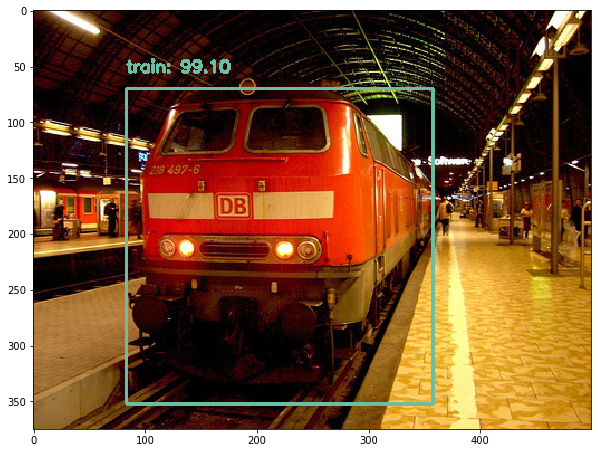

In [41]:
run('/content/SSD/results')